## 코사인 유사도

- `추천 시스템`에서 범주형 벡터를 숫자벡터로 변환하는 과정이 필요하다.
- 숫자벡터 사이의 유사도를 계산해서 높은 유사도의 제품을 추천해준다.
<br>
- 이 때 사용되는 대표적인 유사도 지표가 `코사인 유사도`이다.

코사인 유사도 외에도 `유클리드 거리`, `자카드 유사도`, `피어슨 상관계수` 등의 다른 방법으로 유사도를 계산할 수 있다.


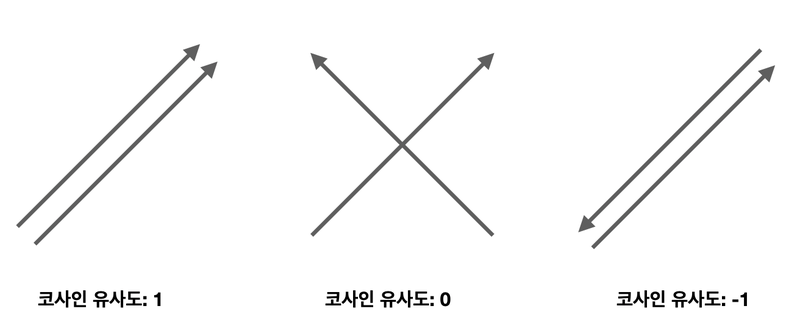
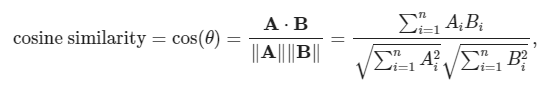

#### Numpy를 활용한 계산

In [1]:
import numpy as np

t1 = np.array([1, 1, 1])
t2 = np.array([2, 0, 1])

In [2]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [3]:
cos_sim(t1, t2)

0.7745966692414834

#### Sklearn 활용

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
t1 = np.array([[1, 1, 1]])
t2 = np.array([[2, 0, 1]])

cosine_similarity(t1,t2)

array([[0.77459667]])

In [8]:
t1 = np.array([[-2, 0, -1]])
t2 = np.array([[2, 0, 1]])

cosine_similarity(t1,t2)

array([[-1.]])

## 추천시스템의 종류

1. 콘텐츠 기반 필터링
2. 협업 필터링
    1) 사용자 기반
    2) 아이템 기반
    3) 잠재요인 협업 필터링 -> 행렬 인수분해(matrix factorization)
3. 딥러닝 적용 or Hybrid 방식

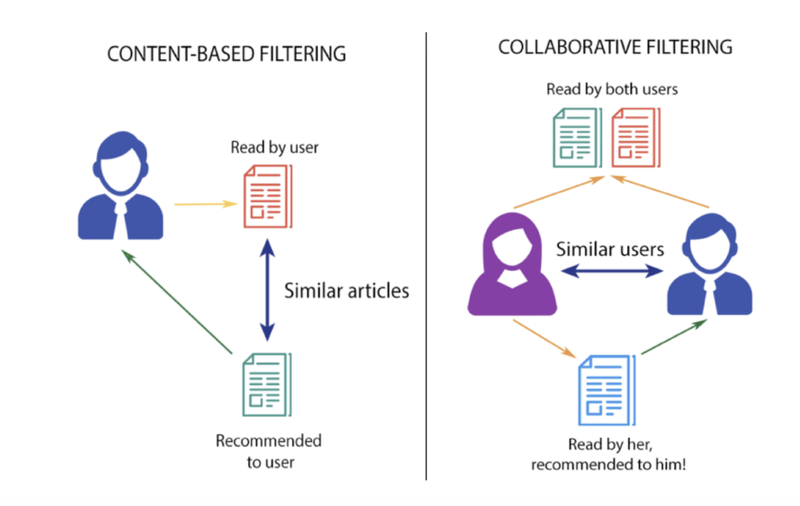

### 1. 콘텐츠 기반 필터링  [[참고 링크]](https://www.codeheroku.com/post.html?name=Building%20a%20Movie%20Recommendation%20Engine%20in%20Python%20using%20Scikit-Learn)

콘텐츠 기반은 순수하게 **콘텐츠의 내용만을 비교해서 추천**하는 방식이다.
- 영화의 특성 : 장르, 배우, 감독, 등의 정보를 갖고 영화를 선정한다.

#### 1) 필요한 모듈과 데이터 불러오기
- 예제 데이터는 **movie_dataset**을 사용한다.

In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
import os

csv_path = os.getenv('HOME')+'/aiffel/movie_recommendation/movie_dataset.csv'
df = pd.read_csv(csv_path)
df.head(3)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes


#### 2) 특성 선택
- 영화의 유사도를 계산하는 데에 있어서 고려할 특성(컬럼)을 선택한다.

In [16]:
features = ['keywords','cast','genres','director']
features

['keywords', 'cast', 'genres', 'director']

In [14]:
def combine_features(row):
    return row['keywords']+" "+row['cast']+" "+row['genres']+" "+row['director']

combine_features(df[:5])

0    culture clash future space war space colony so...
1    ocean drug abuse exotic island east india trad...
2    spy based on novel secret agent sequel mi6 Dan...
3    dc comics crime fighter terrorist secret ident...
4    based on novel mars medallion space travel pri...
dtype: object

In [17]:
for feature in features:
    df[feature] = df[feature].fillna('')

df["combined_features"] = df.apply(combine_features,axis=1)
df["combined_features"]

0       culture clash future space war space colony so...
1       ocean drug abuse exotic island east india trad...
2       spy based on novel secret agent sequel mi6 Dan...
3       dc comics crime fighter terrorist secret ident...
4       based on novel mars medallion space travel pri...
                              ...                        
4798    united states\u2013mexico barrier legs arms pa...
4799     Edward Burns Kerry Bish\u00e9 Marsha Dietlein...
4800    date love at first sight narration investigati...
4801     Daniel Henney Eliza Coupe Bill Paxton Alan Ru...
4802    obsession camcorder crush dream girl Drew Barr...
Name: combined_features, Length: 4803, dtype: object

#### 3) 벡터화하고, 코사인 유사도를 계산합니다.
- 해당 칼럼을 벡터화하고, 코사인 유사도를 계산한다.
- 장르, 배우명, 감독명의 텍스트 데이터를 범주형 데이터로 보기에 간단하게 `CounterVectorizer()`를 통해 확인한다.

In [18]:
cv = CountVectorizer()

count_matrix = cv.fit_transform(df["combined_features"])

In [19]:
print(type(count_matrix))
print(count_matrix.shape)
print(count_matrix)

<class 'scipy.sparse.csr.csr_matrix'>
(4803, 14845)
  (0, 3115)	1
  (0, 2616)	1
  (0, 4886)	1
  (0, 12386)	2
  (0, 14235)	1
  (0, 2755)	1
  (0, 12299)	1
  (0, 11517)	1
  (0, 14561)	1
  (0, 14820)	1
  (0, 11490)	1
  (0, 12134)	1
  (0, 14291)	1
  (0, 12567)	1
  (0, 7496)	1
  (0, 8831)	1
  (0, 11217)	1
  (0, 86)	1
  (0, 144)	1
  (0, 4435)	1
  (0, 11745)	1
  (0, 4566)	1
  (0, 6542)	1
  (0, 2061)	1
  (1, 86)	1
  :	:
  (4801, 10069)	1
  (4801, 5844)	1
  (4801, 252)	1
  (4801, 4098)	1
  (4801, 14796)	1
  (4801, 11361)	1
  (4801, 2978)	1
  (4801, 12036)	1
  (4801, 6138)	1
  (4802, 9659)	1
  (4802, 3812)	1
  (4802, 1788)	2
  (4802, 4210)	1
  (4802, 5181)	1
  (4802, 2912)	1
  (4802, 3821)	1
  (4802, 1069)	1
  (4802, 11185)	1
  (4802, 3681)	1
  (4802, 5399)	1
  (4802, 3894)	1
  (4802, 2056)	1
  (4802, 3093)	1
  (4802, 4502)	1
  (4802, 5900)	2


- count_matrix는 type을 확인해 본 결과, CSR(Compressed Sparse Row) Matrix이다. 
- `CSR Matrix`는 **Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보로만으로 구성**하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조이다.

In [20]:
cosine_sim = cosine_similarity(count_matrix)
print(cosine_sim)
print(cosine_sim.shape)

[[1.         0.10540926 0.12038585 ... 0.         0.         0.        ]
 [0.10540926 1.         0.0761387  ... 0.03651484 0.         0.        ]
 [0.12038585 0.0761387  1.         ... 0.         0.11145564 0.        ]
 ...
 [0.         0.03651484 0.         ... 1.         0.         0.04264014]
 [0.         0.         0.11145564 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.04264014 0.         1.        ]]
(4803, 4803)


#### 4)  코사인 유사도 기반으로 추천

In [40]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]
def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

movie_user_likes = "Avatar"
movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index]))

sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]

i=0
print(movie_user_likes+"와 비슷한 영화 5편은 "+"\n")
for item in sorted_similar_movies:
    print(get_title_from_index(item[0]))
    i=i+1
    if i==5:
        break

Avatar와 비슷한 영화 5편은 

Guardians of the Galaxy
Aliens
Star Wars: Clone Wars: Volume 1
Star Trek Into Darkness
Star Trek Beyond


### 2. 협업 필터링
#### 1) 협업 필터링의 종류

`협업 필터링`은 **과거의 사용자 행동 양식 데이터**를 기반으로 추천하는 방식이다.<br><br>
    - `user_id`에는 유저 정보가, <br>
    - `item_id`에는 영화의 정보, <br>
    - `rating`에는 평점, <br>
    - `timestamp`에는 평점을 매긴 시각이 칼럼에 기록되어 있다.
    
- 이렇게 만든 행렬은 희소행렬 (Sparse Matrix)이기 때문에, 빈 공간이 되게 많이 나온다.
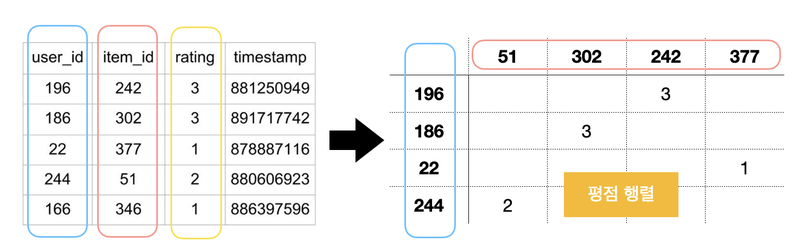



- `협업 필터링`의 종류에는 아래의 세 가지가 존재한다. 
    1. `사용자 기반` 
    2. `아이템 기반`
    3. `잠재요인(latent factor) 방식`
    
    
- `사용자 기반`과 `아이템 기반`은 **유사도**를 계산하는 방식이다.
- `잠재요인`은 **행렬 인수분해**를 이용해 잠재요인을 분석한다.

#### 2) 사용자 기반

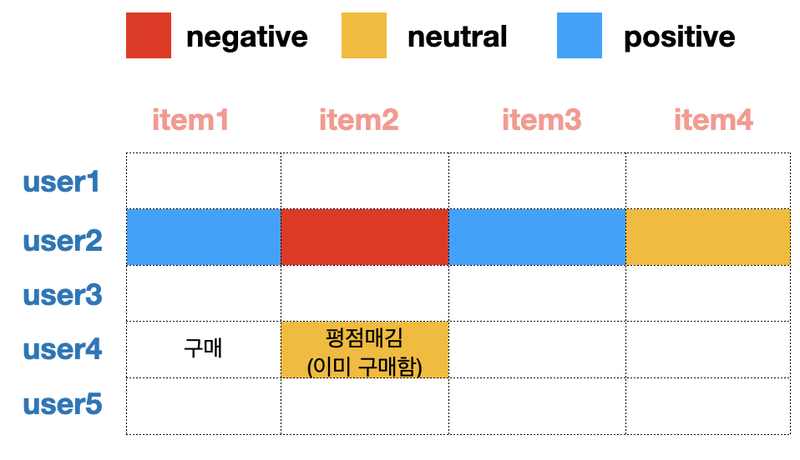

- '비슷한 고객들이 다음과 같은 상품을 구매했다.'로 이해할 수 있다.
- item1을 구매한 User4와 유사한 User2가 구매한 다른 아이템을 추천하는 방식이다.

#### 3) 아이템 기반

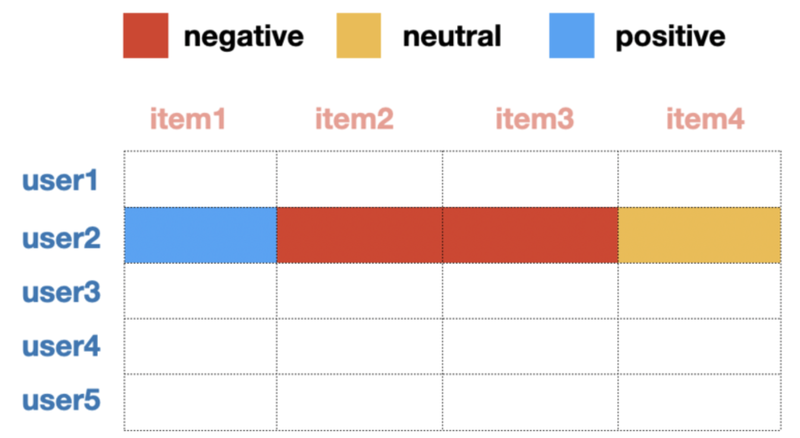
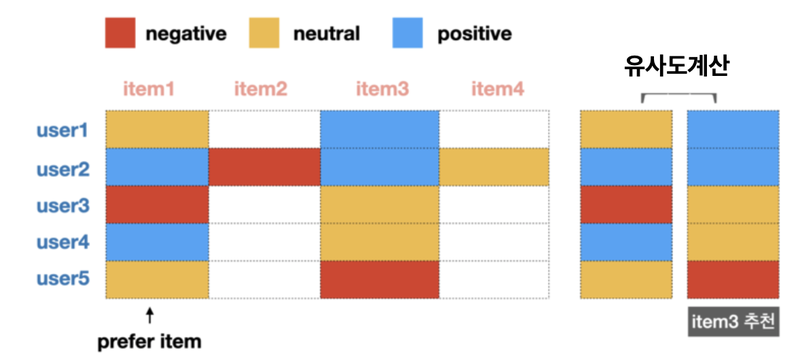

- '이 상품을 선택한 다른 고객들은 다음 상품을 구매했다.'로 이해할 수 있다.
- User2가 item1을 선호하는데, 동이랗게 user4도 선호하기 때문에, user2가 좋아한 상품인 item 3를 user4에게 추천하는 빙식이다.
- 일반적으로 `사용자 기반`보다 `아이템 기반`이 더욱 정확도가 높은 편에 속한다.

## 행렬 인수분해

### 1. SVD(Singular Vector Decomposition)

- 특잇값 분해, M x N 형태의 행렬 A를 다음과 같이 분해하여 나타내는 것을 의미한다.
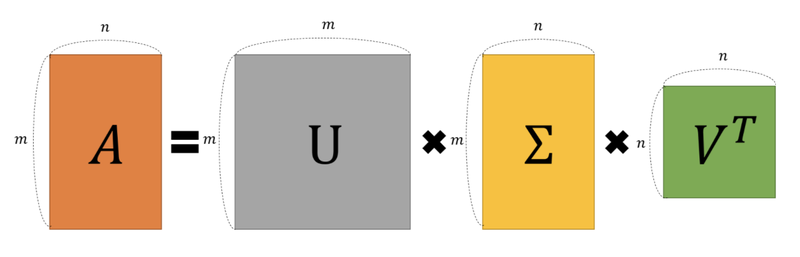

In [42]:
import numpy as np
from numpy.linalg import svd

In [41]:
np.random.seed(30)
A = np.random.randint(0, 100, size=(4, 4))
A

array([[37, 37, 45, 45],
       [12, 23,  2, 53],
       [17, 46,  3, 41],
       [ 7, 65, 49, 45]])

In [43]:
svd(A)

(array([[-0.54937068, -0.2803037 , -0.76767503, -0.1740596 ],
        [-0.3581157 ,  0.69569442, -0.13554741,  0.60777407],
        [-0.41727183,  0.47142296,  0.28991733, -0.72082768],
        [-0.6291496 , -0.46389601,  0.55520257,  0.28411509]]),
 array([142.88131188,  39.87683209,  28.97701433,  14.97002405]),
 array([[-0.25280963, -0.62046326, -0.4025583 , -0.6237463 ],
        [ 0.06881225, -0.07117038, -0.8159854 ,  0.56953268],
        [-0.73215039,  0.61782756, -0.23266002, -0.16767299],
        [-0.62873522, -0.47775436,  0.34348792,  0.50838848]]))

In [44]:
U, Sigma, VT = svd(A)

print('U matrix: {}\n'.format(U.shape),U)
print('Sigma: {}\n'.format(Sigma.shape),Sigma)
print('V Transpose matrix: {}\n'.format(VT.shape),VT)

U matrix: (4, 4)
 [[-0.54937068 -0.2803037  -0.76767503 -0.1740596 ]
 [-0.3581157   0.69569442 -0.13554741  0.60777407]
 [-0.41727183  0.47142296  0.28991733 -0.72082768]
 [-0.6291496  -0.46389601  0.55520257  0.28411509]]
Sigma: (4,)
 [142.88131188  39.87683209  28.97701433  14.97002405]
V Transpose matrix: (4, 4)
 [[-0.25280963 -0.62046326 -0.4025583  -0.6237463 ]
 [ 0.06881225 -0.07117038 -0.8159854   0.56953268]
 [-0.73215039  0.61782756 -0.23266002 -0.16767299]
 [-0.62873522 -0.47775436  0.34348792  0.50838848]]


In [45]:
Sigma_mat = np.diag(Sigma)

A_ = np.dot(np.dot(U, Sigma_mat), VT)
A_

array([[37., 37., 45., 45.],
       [12., 23.,  2., 53.],
       [17., 46.,  3., 41.],
       [ 7., 65., 49., 45.]])

- 추천 시스템에서의 행렬 인수분해는 SVD 중에서도 `Truncated SVD`를 활용한다.

1. **계산비용** : `SVD`는 전체 데이터에 대한 분해를 수행하므로 계산 비용이 크다.<br> 반면 `Truncated SVD`는 몇 개의 주요한 특이값과 이에 대응하는 특이 벡터만 선택하기 때문에 계산비용이 적다. <br><br>
2. **노이즈 제거** : `Truncated SVD`는 작은 특이값을 제거하고 이에 대응하는 특이 벡터를 사용하기 때문에, 노이즈를 제거하고 중요한 정보를 유지하는 효과가 있다.<br><br>
3. **해석 가능성** : `SVD`는 전체 데이터에 대한 분해를 수행하므로, 각 특이벡터가 전체 데이터에서 어떤 의미를 가지는지 해석하기 쉽다. <br>
    반면, `Truncated SVD`는 전체 데이터를 대표하는 특이벡터 중에서 일부만 선택하기 때문에 전체 데이터에 대한 해석이 어렵다. <br><br>
4. **메모리 사용**: `SVD`는 전체 데이터에 대한 분해를 하기에 메모리 사용량이 큰 반면,<br> `Truncated SVD`는 몇 개의 주요한 특이값과 이에 대응하는 특이 벡터만 선택하기 때문에 메모리 사용량이 상대적으로 적다.


## 행렬 인수분해와 잠재요인 협업 필터링

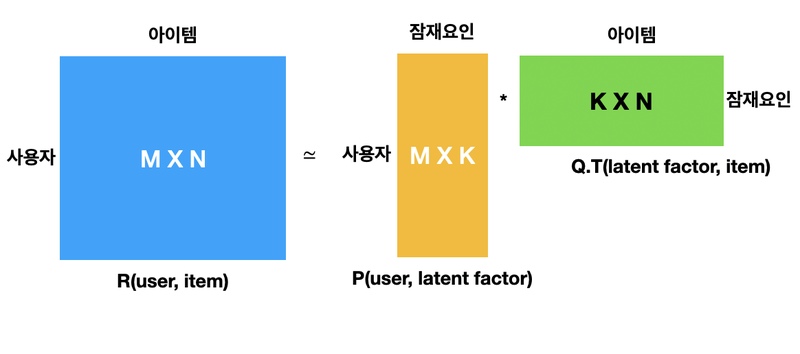

- R: 사용자와 아이템 사이의 행렬
- P: 사용자와 잠재요인 사이의 행렬
- Q: 아이템과 잠재요인 사이의 행렬 —> 전치 행렬 형태로 나타냄

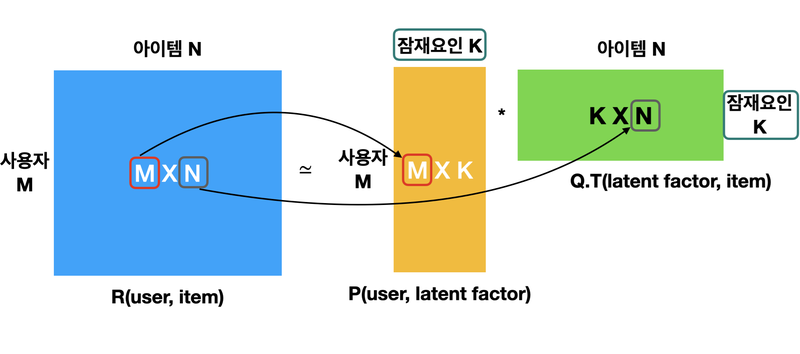